- kaggle: https://www.kaggle.com/jangedoo/utkface-new
- dataset: https://susanqq.github.io/UTKFace/

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image

tf.__version__

'2.1.0'

In [27]:
# configs
DATA_DIR = '/home/jackon/datasets/UTKFace/UTKFace'
# ! ls /home/jackon/datasets/UTKFace/UTKFace | wc -l

TRAIN_TEST_SPLIT = 0.7
IMAGE_HEIGHT, IMAGE_WIDTH = 198, 198
IMAGE_CHANNELS = 3
ID_GENDER_MAP = {0: 'male', 1: 'female'}
GENDER_ID_MAP = {g: i for i, g in ID_GENDER_MAP.items()}
ID_RACE_MAP = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}
RACE_ID_MAP = {r: i for i, r in ID_RACE_MAP.items()}

ID_GENDER_MAP, GENDER_ID_MAP, ID_RACE_MAP, RACE_ID_MAP

({0: 'male', 1: 'female'},
 {'male': 0, 'female': 1},
 {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'},
 {'white': 0, 'black': 1, 'asian': 2, 'indian': 3, 'others': 4})

In [3]:
def parse_filepath(filepath):
    try:
        path, filename = os.path.split(filepath)
        filename, ext = os.path.splitext(filename)
        age, gender, race, _ = filename.split("_")
        return int(age), ID_GENDER_MAP[int(gender)], ID_RACE_MAP[int(race)]
    except Exception as e:
        print('error to parse %s. %s' % (filepath, e))
        return None, None, None

In [5]:
# create a pandas data frame of images, age, gender and race
files = glob.glob(os.path.join(DATA_DIR, "*.jpg"))
attributes = list(map(parse_filepath, files))

df_origin = pd.DataFrame(attributes)
df_origin['file'] = files
df_origin.columns = ['age', 'gender', 'race', 'file']
df_origin = df_origin.dropna()
df_origin.head()

error to parse /home/jackon/datasets/UTKFace/UTKFace/61_1_20170109142408075.jpg.chip.jpg. not enough values to unpack (expected 4, got 3)
error to parse /home/jackon/datasets/UTKFace/UTKFace/61_1_20170109150557335.jpg.chip.jpg. not enough values to unpack (expected 4, got 3)
error to parse /home/jackon/datasets/UTKFace/UTKFace/39_1_20170116174525125.jpg.chip.jpg. not enough values to unpack (expected 4, got 3)


,age,gender,race,file
0,27.0,male,indian,/home/jackon/datasets/UTKFace/UTKFace/27_0_3_2...
1,36.0,male,indian,/home/jackon/datasets/UTKFace/UTKFace/36_0_3_2...
2,26.0,male,black,/home/jackon/datasets/UTKFace/UTKFace/26_0_1_2...
3,45.0,male,indian,/home/jackon/datasets/UTKFace/UTKFace/45_0_3_2...
4,35.0,female,white,/home/jackon/datasets/UTKFace/UTKFace/35_1_0_2...


# Exploratory analysis

In [6]:
df_origin.describe()

,age
count,23705.000000
mean,33.300907
std,19.885708
min,1.000000
25%,23.000000
50%,29.000000
75%,45.000000
max,116.000000


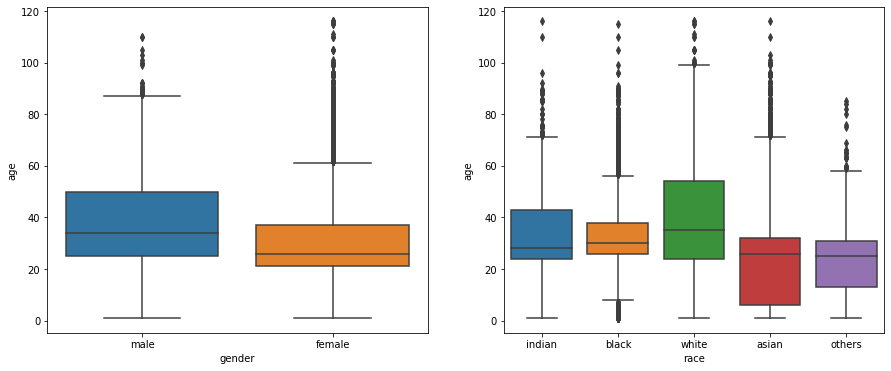

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
sns.boxplot(data=df_origin, x='gender', y='age', ax=ax1)
sns.boxplot(data=df_origin, x='race', y='age', ax=ax2)

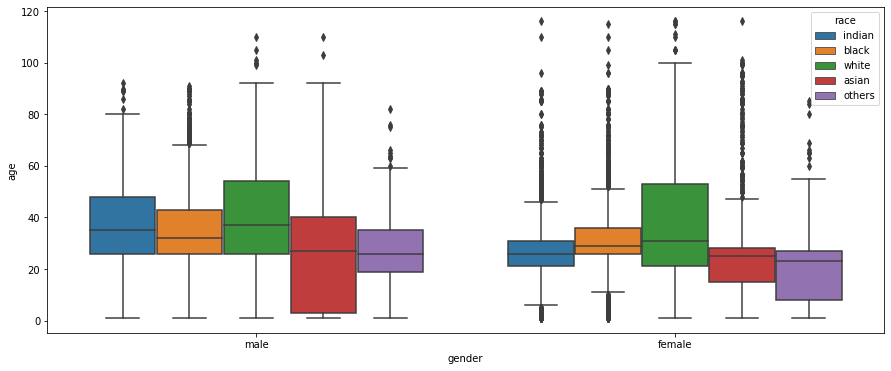

In [10]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=df_origin, x='gender', y='age', hue='race')

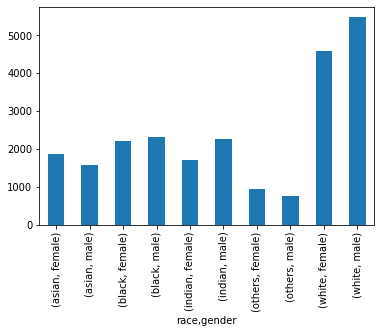

In [12]:
df_origin.groupby(by=['race', 'gender'])['age'].count().plot(kind='bar')

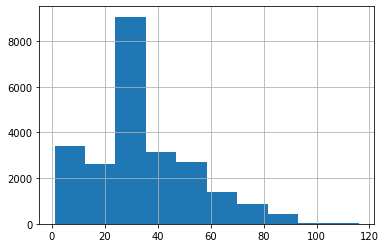

In [14]:
df_origin['age'].hist()

In [15]:
df_origin['age'].describe()

count    23705.000000
mean        33.300907
std         19.885708
min          1.000000
25%         23.000000
50%         29.000000
75%         45.000000
max        116.000000
Name: age, dtype: float64

从 上面的分析看出，年龄在 10-65 岁之间的人口占据绝大多数，这个区域外的样本很少，需要选择性的丢弃。

In [21]:
df = df_origin.copy()
df = df[(df['age'] > 10) & (df['age'] < 65)]
df.describe()

,age
count,18529.000000
mean,33.939230
std,12.300058
min,11.000000
25%,26.000000
50%,30.000000
75%,41.000000
max,64.000000


In [22]:
df.head()

,age,gender,race,file
0,27.0,male,indian,/home/jackon/datasets/UTKFace/UTKFace/27_0_3_2...
1,36.0,male,indian,/home/jackon/datasets/UTKFace/UTKFace/36_0_3_2...
2,26.0,male,black,/home/jackon/datasets/UTKFace/UTKFace/26_0_1_2...
3,45.0,male,indian,/home/jackon/datasets/UTKFace/UTKFace/45_0_3_2...
4,35.0,female,white,/home/jackon/datasets/UTKFace/UTKFace/35_1_0_2...


# data preprocess

In [23]:
p = np.random.permutation(len(df))
train_up_to = int(len(df) * TRAIN_TEST_SPLIT)
train_idx = p[:train_up_to]
test_idx = p[train_up_to:]

# split train_idx further into training and validation set
train_up_to = int(train_up_to * 0.7)
train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]

df['gender_id'] = df['gender'].map(lambda gender: GENDER_ID_MAP[gender])
df['race_id'] = df['race'].map(lambda race: RACE_ID_MAP[race])

max_age = df['age'].max()
print('train count: %s, valid count: %s, test count: %s, max age: %s' % (
    len(train_idx), len(valid_idx), len(test_idx), max_age))

train count: 9079, valid count: 3891, test count: 5559, max age: 64.0


In [24]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

def get_data_generator(df, indices, for_training, batch_size=16):
    images, ages, races, genders = [], [], [], []
    while True:
        for i in indices:
            r = df.iloc[i]
            file, age, race, gender = r['file'], r['age'], r['race_id'], r['gender_id']
            im = Image.open(file)
            im = im.resize((IM_WIDTH, IM_HEIGHT))
            im = np.array(im) / 255.0
            images.append(im)
            ages.append(age / max_age)
            races.append(to_categorical(race, len(RACE_ID_MAP)))
            genders.append(to_categorical(gender, 2))
            if len(images) >= batch_size:
                yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                images, ages, races, genders = [], [], [], []
        if not for_training:
            break

# Model training

In [29]:
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, MaxPool2D, GlobalMaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Model

def conv_block(input_data, filters=32, bn=True, pool=True, kernel_size=3, activation='relu'):
    x = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation)(input_data)
    if bn:
        x = BatchNormalization()(x)
    if pool:
        x = MaxPool2D()(x)
    return x

input_layer = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS))
x = conv_block(input_layer, filters=32, bn=False, pool=False)
x = conv_block(x, filters=32*2)
x = conv_block(x, filters=32*3)
x = conv_block(x, filters=32*4)
x = conv_block(x, filters=32*5)
x = conv_block(x, filters=32*6)
bottleneck = GlobalMaxPool2D()(x)

# for age calculation
age_x = Dense(128, activation='relu')(bottleneck)
age_output = Dense(1, activation='sigmoid', name='age_output')(age_x)

# for race prediction
race_x = Dense(128, activation='relu')(bottleneck)
race_output = Dense(len(RACE_ID_MAP), activation='softmax', name='race_output')(race_x)

# for gender prediction
gender_x = Dense(128, activation='relu')(bottleneck)
gender_output = Dense(len(GENDER_ID_MAP), activation='softmax', name='gender_output')(gender_x)

model = Model(inputs=input_layer, outputs=[age_output, race_output, gender_output])
model.compile(optimizer='rmsprop', 
              loss={
                  'age_output': 'mse',
                  'race_output': 'categorical_crossentropy',
                  'gender_output': 'categorical_crossentropy'},
              loss_weights={
                  'age_output': 2.,
                  'race_output': 1.5,
                  'gender_output': 1.},
              metrics={
                  'age_output': 'mae',
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 198, 198, 3) 0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 196, 196, 32) 896         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 194, 194, 64) 18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 194, 194, 64) 256         conv2d_3[0][0]                   
______________________________________________________________________________________________

In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint

batch_size = 64
valid_batch_size = 64
train_gen = get_data_generator(df, train_idx, for_training=True, batch_size=batch_size)
valid_gen = get_data_generator(df, valid_idx, for_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=10,
#                     callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

Train for 141 steps, validate for 60 steps
Epoch 1/10
141/141 [==============================] - 45s 318ms/step - loss: 2.9105 - age_output_loss: 0.0828 - race_output_loss: 1.3572 - gender_output_loss: 0.7091 - age_output_mae: 0.2326 - race_output_accuracy: 0.5020 - gender_output_accuracy: 0.7021 - val_loss: 3.9433 - val_age_output_loss: 0.0409 - val_race_output_loss: 1.8449 - val_gender_output_loss: 1.0942 - val_age_output_mae: 0.1766 - val_race_output_accuracy: 0.4083 - val_gender_output_accuracy: 0.5227
Epoch 2/10
141/141 [==============================] - 41s 293ms/step - loss: 1.9236 - age_output_loss: 0.0444 - race_output_loss: 0.9821 - gender_output_loss: 0.3616 - age_output_mae: 0.1694 - race_output_accuracy: 0.6392 - gender_output_accuracy: 0.8506 - val_loss: 2.8227 - val_age_output_loss: 0.0381 - val_race_output_loss: 1.4418 - val_gender_output_loss: 0.5837 - val_age_output_mae: 0.1638 - val_race_output_accuracy: 0.4589 - val_gender_output_accuracy: 0.6482
Epoch 3/10
141/141 

In [33]:
print('\n'.join(history.history.keys()))

loss
age_output_loss
race_output_loss
gender_output_loss
age_output_mae
race_output_accuracy
gender_output_accuracy
val_loss
val_age_output_loss
val_race_output_loss
val_gender_output_loss
val_age_output_mae
val_race_output_accuracy
val_gender_output_accuracy


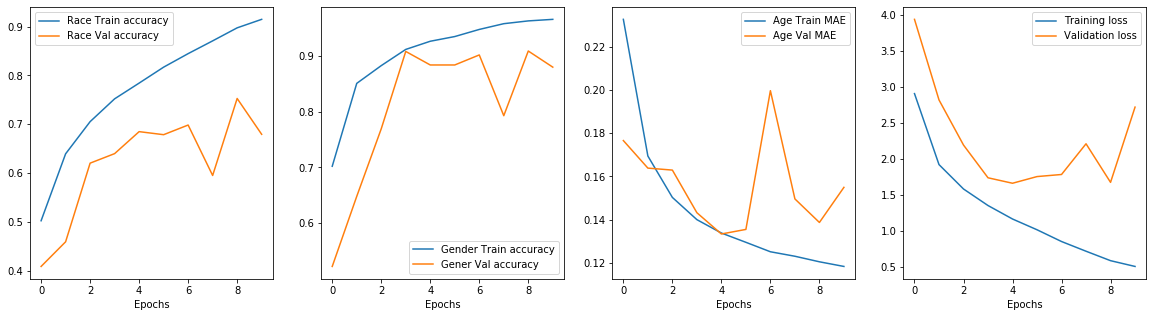

In [34]:
def  plot_train_history(history):
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    axes[0].plot(history.history['race_output_accuracy'], label='Race Train accuracy')
    axes[0].plot(history.history['val_race_output_accuracy'], label='Race Val accuracy')
    axes[0].set_xlabel('Epochs')
    axes[0].legend()
    
    axes[1].plot(history.history['gender_output_accuracy'], label='Gender Train accuracy')
    axes[1].plot(history.history['val_gender_output_accuracy'], label='Gener Val accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].legend()

    axes[2].plot(history.history['age_output_mae'], label='Age Train MAE')
    axes[2].plot(history.history['val_age_output_mae'], label='Age Val MAE')
    axes[2].set_xlabel('Epochs')
    axes[2].legend()  

    axes[3].plot(history.history['loss'], label='Training loss')
    axes[3].plot(history.history['val_loss'], label='Validation loss')
    axes[3].set_xlabel('Epochs')
    axes[3].legend()

plot_train_history(history)

In [35]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
dict(zip(model.metrics_names, model.evaluate(test_gen, steps=len(test_idx)//128)))

43/43 [==============================] - 11s 246ms/step - loss: 2.7884 - age_output_loss: 0.0356 - race_output_loss: 1.5752 - gender_output_loss: 0.3544 - age_output_mae: 0.1541 - race_output_accuracy: 0.6721 - gender_output_accuracy: 0.8826


{'loss': 2.7884030619332956,
 'age_output_loss': 0.035611186,
 'race_output_loss': 1.5751884,
 'gender_output_loss': 0.35439795,
 'age_output_mae': 0.15408821,
 'race_output_accuracy': 0.6720567,
 'gender_output_accuracy': 0.8826308}

In [84]:
test_gen = get_data_generator(df, test_idx, for_training=False, batch_size=128)
x_test, (age_true, race_true, gender_true)= next(test_gen)
age_pred, race_pred, gender_pred = model.predict_on_batch(x_test)

race_pred, gender_pred = tf.math.argmax(race_pred, axis=1), tf.math.argmax(gender_pred, axis=1)
race_true, gender_true = tf.math.argmax(race_true, axis=1), tf.math.argmax(gender_true, axis=1)
age_true = age_true * max_age
age_pred = age_pred * max_age

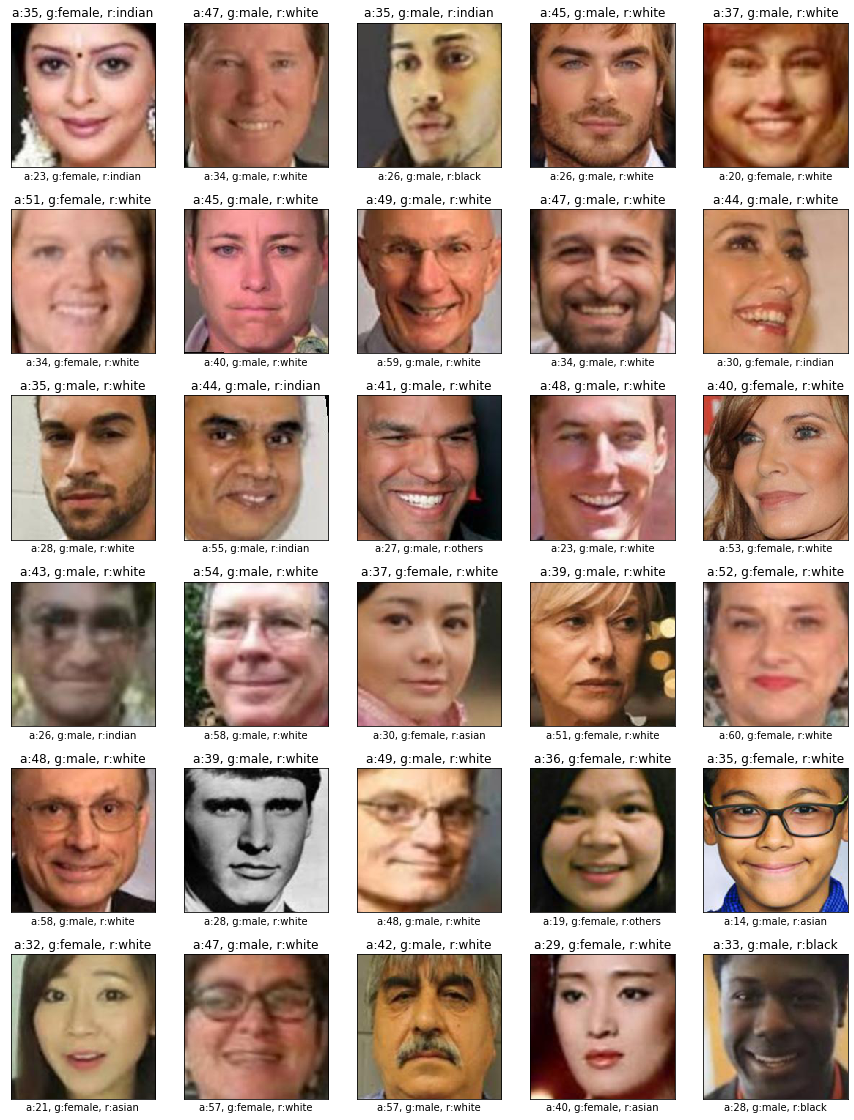

In [85]:
import math
n = 30
random_indices = np.random.permutation(n)
n_cols = 5
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    ax.imshow(x_test[img_idx])
    ax.set_title('a:{}, g:{}, r:{}'.format(
        int(age_pred[img_idx].numpy()),
        ID_GENDER_MAP[gender_pred[img_idx].numpy()],
        ID_RACE_MAP[race_pred[img_idx].numpy()]))
    ax.set_xlabel('a:{}, g:{}, r:{}'.format(
        int(age_true[img_idx]), ID_GENDER_MAP[gender_true[img_idx].numpy()], ID_RACE_MAP[race_true[img_idx].numpy()]))
    ax.set_xticks([])
    ax.set_yticks([])

In [70]:
from sklearn.metrics import classification_report
print("Classification report for race")
print(classification_report(race_true, race_pred, labels=list(ID_RACE_MAP.keys())))

print("\nClassification report for gender")
print(classification_report(gender_true, gender_pred, labels=list(ID_GENDER_MAP.keys())))

Classification report for race
              precision    recall  f1-score   support

           0       0.59      0.98      0.74        56
           1       0.88      0.72      0.79        29
           2       1.00      0.20      0.33        15
           3       0.62      0.29      0.40        17
           4       0.00      0.00      0.00        11

    accuracy                           0.66       128
   macro avg       0.62      0.44      0.45       128
weighted avg       0.66      0.66      0.59       128


Classification report for gender
              precision    recall  f1-score   support

           0       0.82      0.96      0.88        74
           1       0.93      0.70      0.80        54

    accuracy                           0.85       128
   macro avg       0.87      0.83      0.84       128
weighted avg       0.86      0.85      0.85       128

